## RMSProp算法

AdaGrad算法的问题是，当学习率在迭代早期降得较快且当前解依然不佳时，AdaGrad算法在迭代后期由于学习率过小，可能较难找到一个有用的解。可以对AdaGrad做一些调整，使得学习率不要一直降低。

具体地，在每一时间步$t$，变量$\vec{s}_t$按如下方式更新：

$$
\vec{s}_t \leftarrow \gamma \vec{s}_{t-1} + (1 - \gamma) \vec{g}_{t} \odot \vec{g}_t,
$$

其中$\gamma \in [0,1)$。待优化参数$\vec{x}_t$的更新方式保持不变：

$$
\vec{x}_t \leftarrow \vec{x}_{t-1} - \frac{\eta}{\sqrt{\vec{s}_t + \epsilon}} \odot \vec{g}_t,
$$

其中$\eta$是学习率，$\epsilon$是为了维持数值稳定性而添加的常数，如$10^{-6}$。

此时$\vec{s}_t$是对平方项$\vec{g}_{t} \odot \vec{g}_t$的指数加权移动平均，因此$\vec{s}_t$可能变大也可能变小，从而保证学习率不会一直减小。

epoch 20, x1 -0.010599, x2 0.000000


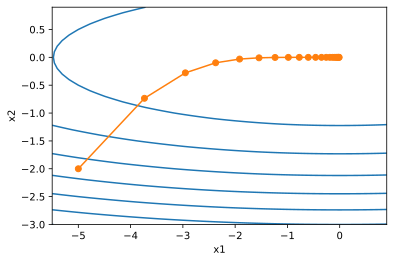

In [1]:
%matplotlib inline
import math
import torch
import sys
import my_utils
import matplotlib.pyplot as plt
import numpy as np

def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
# my_utils.show_trace_2d(f_2d, my_utils.train_2d(rmsprop_2d))
my_utils.use_svg_display()
plt.plot(*zip(*my_utils.train_2d(rmsprop_2d)), '-o', color='#ff7f0e')
x1, x2 = np.meshgrid(np.arange(-5.5, 1.0, 0.1), np.arange(-3.0, 1.0, 0.1))
plt.contour(x1, x2, f_2d(x1, x2), colors='#1f77b4')
plt.xlabel('x1')
plt.ylabel('x2')
plt.savefig('prop.svg')

和07-3的图1对比，可发现此时可以找到极值点。

### 1 从零开始实现

In [5]:
features, labels = my_utils.get_NASA_data()

def init_rmsprop_states():
    s_w = torch.zeros((features.shape[1], 1), dtype=torch.float32)
    s_b = torch.zeros(1, dtype=torch.float32)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        s.data = gamma * s.data + (1 - gamma) * (p.grad.data)**2
        p.data -= hyperparams['lr'] * p.grad.data / torch.sqrt(s + eps)

loss: 0.244284, 0.068933 sec per epoch


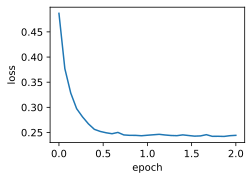

In [6]:
my_utils.opt_train(rmsprop, init_rmsprop_states(), {'lr': 0.01, 'gamma': 0.9},
                   features, labels)

### 2 简洁实现

loss: 0.247585, 0.056294 sec per epoch


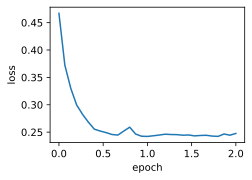

In [7]:
my_utils.opt_train_torch(torch.optim.RMSprop, {'lr': 0.01, 'alpha': 0.9},
                         features, labels)